# Imports

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import operator
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from ipywidgets import FloatProgress
from IPython.display import display
import operator
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# EMPLOYMENT DYNAMICS

## Table of Contents 

1 - [Cleaning the Data](#clean)<br>
2 - [Visualizations: EDA](#vis)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 - [Word_Clouds](#wc)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1a - [Berkeley Alumni Females](#bf)<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1b - [Berkeley Alumni Males](#bm)<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2c - [Non-Berkeley Alumni Females](#nf)<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2d - [Non-Berkeley Alumni Males](#nm)<br> 
3 - [Code for Implementation](#implementation)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 - [Duration between Last Education and First Tech Job](#duration)<br>
4 - [Linear Regression](#lr)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1 - [Loss Function](#lf)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a - [Berkeley Alumni Model](#bm)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b - [Non-Berkeley Alumni Model](#nm)<br>
6 - [Data Schema](#ds)<br>

In [2]:
col = ['ID', 'Birth_Year', 'Gender', 'Skill_1', 'Skill_1_Weight', 'Skill_2', 'Skill_2_Weight', "City_Of_Profile",
          'Country_Of_Profile', 'Education', 'Elite_Institution', 'Start_Date', 'Valid_Start_Date', 
           'End_Date', 'Valid_End_Date', 'Current_Employer_Flag', 'Length_At_Job', 'Role', 'Department',
          'Company', 'Normalized_Company', 'Ticker', 'Exchange', 'Publicly_Traded', 'Location_Of_Employment',
           'Industry', 'Education_Flag', 'Degree_Type', 'Elite_Flag', 'Majors', 'Major_Categories' , 'Unknown1', 'Unknown2']

In [3]:
bay_area_df = pd.read_csv('bay_area.csv',
                       sep = '\t', 
                       header = None)
bay_area_df.columns = col
bay_area_df = bay_area_df.drop(['Unknown1', 'Unknown2', 'Major_Categories', 'Normalized_Company', 
                                'Ticker', 'Exchange', 'Publicly_Traded', 'Location_Of_Employment', 
                                "City_Of_Profile",'Country_Of_Profile', 'Elite_Flag', 'Majors', 'Elite_Institution'], axis = 1)

C:\Users\talin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,12,14,15,23,26,27,28,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df_id, test_df_id = train_test_split(bay_area_df['ID'].unique(), test_size=0.2, random_state=1)

train_df_id, val_df_id = train_test_split(train_df_id, test_size=0.2, random_state=1)


In [5]:
bay_area = bay_area_df[(bay_area_df['ID'].isin(train_df_id)) | (bay_area_df['ID'].isin(val_df_id))]
train_df = bay_area_df[bay_area_df['ID'].isin(train_df_id)]
val_df = bay_area_df[bay_area_df['ID'].isin(val_df_id)]
test_df = bay_area_df[bay_area_df['ID'].isin(test_df_id)]

# Cleaning the Data<a id='clean'></a> 

#### This is where we filtered the data into specific tables that we were interested in analyzing.

In [6]:
bay_area = bay_area[(bay_area['Start_Date'] != 'None') | (bay_area['End_Date'] != 'None')]

In [7]:
test_df = test_df[(test_df['Start_Date'] != 'None') | (test_df['End_Date'] != 'None')]

In [9]:
#making all the items in role into lower case strings
bay_area["Role"] = bay_area["Role"].str.lower()
test_df["Role"] = test_df["Role"].str.lower()

In [10]:
num_edu = [4,5,6,7]

In [11]:
berk_edu = bay_area.loc[(bay_area["Degree_Type"].isin(num_edu)) 
                        & ((bay_area["Company"] == "UC Berkeley") 
                           | (bay_area["Company"] == "University of California, Berkeley")) 
                        & (bay_area["Education_Flag"] == 1)]
berk_edu = bay_area[bay_area['ID'].isin(list(berk_edu['ID'])) & (bay_area["Education_Flag"] == 1)]

In [12]:
berk_edu.to_csv('berk_edu.csv', index = False)

In [13]:
non_berk_edu = bay_area.loc[(bay_area["Degree_Type"].isin(num_edu)) 
                            & ((bay_area["Company"] != "UC Berkeley") 
                               | (bay_area["Company"] != "University of California, Berkeley")) 
                            & (bay_area["Education_Flag"] == 1)
                           & ~bay_area['ID'].isin(list(berk_edu['ID']))]

In [14]:
non_berk_edu.to_csv('non_berk_edu.csv', index = False)

# EDA on features: Gender and Degree Type

In [15]:
berk_edu_4 = berk_edu[berk_edu['Education'] == 4]
berk_edu_5 = berk_edu[berk_edu['Education'] == 5]
berk_edu_6 = berk_edu[berk_edu['Education'] == 6]
berk_edu_7 = berk_edu[berk_edu['Education'] == 7]

In [16]:
berk_edu_4_f = berk_edu_4[berk_edu_4["Gender"] == 1]
berk_edu_4_m = berk_edu_4[berk_edu_4["Gender"] == 2]
berk_edu_5_f = berk_edu_5[berk_edu_5["Gender"] == 1]
berk_edu_5_m = berk_edu_5[berk_edu_5["Gender"] == 2]
berk_edu_6_f = berk_edu_6[berk_edu_6["Gender"] == 1]
berk_edu_6_m = berk_edu_6[berk_edu_6["Gender"] == 2]
berk_edu_7_f = berk_edu_7[berk_edu_7["Gender"] == 1]
berk_edu_7_m = berk_edu_7[berk_edu_7["Gender"] == 2]

**Here, we separate the ID's by male and female identification**

In [17]:
berk_edu_girl = berk_edu.loc[berk_edu["Gender"] == 1]
berk_edu_boy = berk_edu.loc[berk_edu["Gender"] == 2]

# Visualizations | EDA<a id='vis'></a> 



**Here we have made a graph displaying the separation of males vs females attending Berkeley: not in the work force, but just at the school.**
- for reference, 4 years is about 1500 days 

<Figure size 432x288 with 0 Axes>

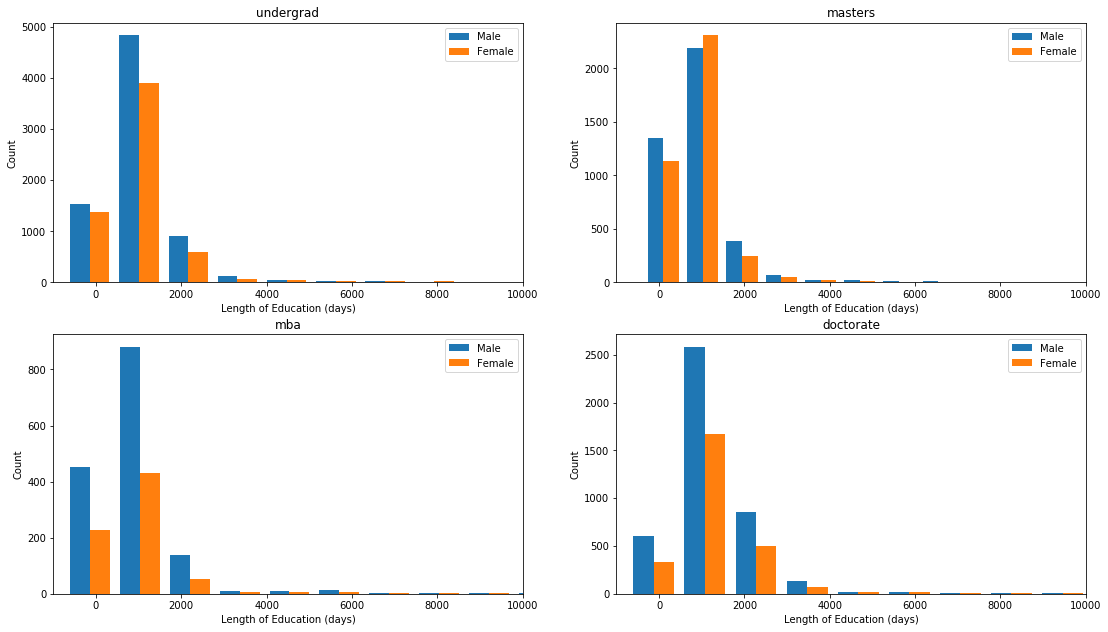

In [18]:
fig = plt.gcf()
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].hist([berk_edu_4_m["Length_At_Job"], berk_edu_4_f["Length_At_Job"]], bins = 25, label = ("Male", "Female"))
ax[0, 0].set_title("undergrad")
ax[0, 0].legend()
ax[0, 0].set_xlabel('Length of Education (days)')
ax[0, 0].set_ylabel('Count')
ax[0, 0].set_xlim((-1000,10000))


ax[0, 1].hist([berk_edu_5_m["Length_At_Job"], berk_edu_5_f["Length_At_Job"]], bins = 25, label = ("Male", "Female"))
ax[0, 1].set_title("masters")
ax[0, 1].legend()
ax[0, 1].set_xlabel('Length of Education (days)')
ax[0, 1].set_ylabel('Count')
ax[0, 1].set_xlim((-1000,10000))

ax[1, 0].hist([berk_edu_6_m["Length_At_Job"], berk_edu_6_f["Length_At_Job"]], bins = 25, label = ("Male", "Female"))
ax[1, 0].set_title("mba")
ax[1, 0].legend()
ax[1, 0].set_xlabel('Length of Education (days)')
ax[1, 0].set_ylabel('Count')
ax[1, 0].set_xlim((-1000,10000))


ax[1, 1].hist([berk_edu_7_m["Length_At_Job"], berk_edu_7_f["Length_At_Job"]], bins = 25, label = ("Male", "Female"))
ax[1, 1].set_title("doctorate")
ax[1, 1].legend()
ax[1, 1].set_xlabel('Length of Education (days)')
ax[1, 1].set_ylabel('Count')
ax[1, 1].set_xlim((-1000,10000))
fig.set_size_inches(18.5, 10.5, forward=True)
plt.legend()

### Explanation : 
 * The visualizations show the difference degree types among: undergrad, masters, mba, and phd between males and females that graduated from UC Berkeley.  
 * In most cases, we can observe that the male count surpasses the female count in every degree type.
 * For reference:
          - four years is about 1500 days
          - five years is about 2000 days

#### Bay area berk is the data points for jobs of UC Berkeley alumni

In [19]:
berk_id = berk_edu["ID"].unique()

In [20]:
bay_area_not_berk = bay_area.loc[(~bay_area["ID"].isin(berk_id)) 
                                 & (bay_area['Education_Flag'] == False)]

In [21]:
bay_area_not_berk.to_csv('Bay_Area_Not_Berk.csv')

In [23]:
test = bay_area[bay_area['Length_At_Job'] < 0]

In [24]:
test2 = bay_area[bay_area['Length_At_Job'] > 20000]

In [25]:
len(test), len(test2)

(1809, 676)

#### Bay area not berk is the data points for jobs of non-UC Berkeley alumni

In [26]:
bay_area_berk = bay_area.loc[(bay_area["Length_At_Job"] < 25000)
                             & (bay_area["ID"].isin(berk_id)) 
                             & (bay_area['Education_Flag'] == False)]

In [27]:
bay_area_berk.to_csv('Bay_Area_Berk.csv')

### Making two tables to distinguish between the females and males that graduated from Berkeley

In [29]:
bay_area_berk_fem =  bay_area_berk.loc[(bay_area_berk['Valid_End_Date'] == 1) 
                                       & (bay_area_berk['Valid_Start_Date'] == 1) 
                                       & (bay_area_berk["Gender"] == 1) 
                                       & (bay_area_berk['Length_At_Job'] > 0)]
bay_area_berk_ma =  bay_area_berk.loc[(bay_area_berk['Valid_End_Date'] == 1) 
                                      & (bay_area_berk['Valid_Start_Date'] == 1) 
                                      & (bay_area_berk["Gender"] == 2) 
                                      & (bay_area_berk['Length_At_Job'] > 0)]

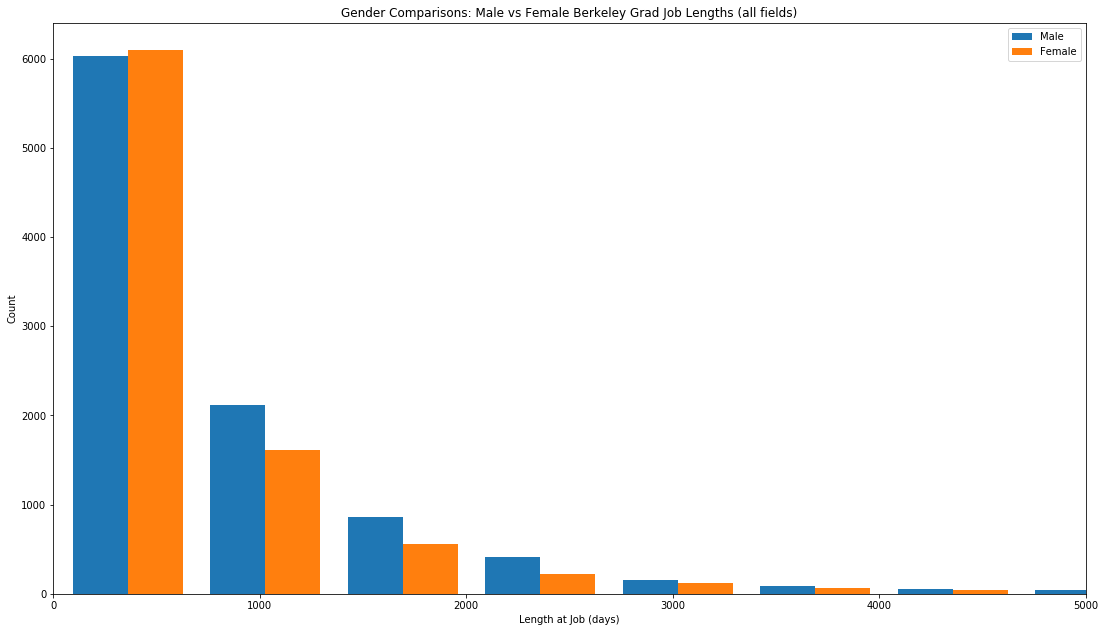

In [31]:
fig = plt.gcf()
plt.hist([bay_area_berk_ma["Length_At_Job"], bay_area_berk_fem["Length_At_Job"]], bins = 25, label = ("Male", "Female"))
fig.set_size_inches(18.5, 10.5, forward=True)
plt.title('Gender Comparisons: Male vs Female Berkeley Grad Job Lengths (all fields)')
plt.xlabel('Length at Job (days)')
plt.ylabel('Count')
plt.xlim((0, 5000))
plt.legend()

### Explanation : 
 * The visualization is a representation of lengths at jobs for males and females that graudated from UC Berkeley. 
 * In most cases, we can observe that there is a higher proportion of males at each job length than women.
 * In addition, most people change jobs at around 1000 days (approximately 3 years).
 * For reference:
          - four years is about 1500 days
          - five years is about 2000 days

In [32]:
IDs = bay_area_not_berk['ID'].unique()

In [33]:
job_role_keywords = ['eecs', 'mathematics', 'engineering', 'computer science', 'cs',
                     'applied mathematics', 'bioengineering', 'data science', 'data analytics', 'data', 
                     'process', 'scientist', 'software engineer', 'engineer', 'bioengineer', 'software', 
                     'web', 'lab','technian', 'development', 'engineer,software']

In [34]:
industry_keys = ['541330', '541714', '541713', '488490', '927110', 
                 '541715', '518210', '541513']

In [35]:
department_keywords = ["TECHNOLOGY", "OPERATIONS"]

In [36]:
def find_words(col, words):
    # one hot encoding for key words in columns
    # ie. "Technology" within the department column
    a = [0]*(len(col))
    for i in words:
        for j in range(len(col)):
            if a[j] == 0:
                a[j] = i in str(col.iloc[j])
    return a

#### Getting key words from the columns that give us information about the Tech Industry

In [37]:
col_dept = find_words(bay_area_berk["Department"], department_keywords)

In [38]:
random_ids4 = np.random.choice(bay_area_not_berk['ID'].unique(), len(bay_area_berk['ID'].unique()) , replace=False)

In [39]:
bay_area_not_berk = bay_area_not_berk[bay_area_not_berk["ID"].isin(random_ids4)]

In [40]:
col_dept_notb = find_words(bay_area_not_berk["Department"], department_keywords)

In [41]:
col_ind = find_words(bay_area_berk["Industry"], industry_keys)

In [42]:
col_ind_notb = find_words(bay_area_not_berk["Industry"], industry_keys)

In [43]:
col_role = find_words(bay_area_berk["Role"], job_role_keywords)

In [44]:
col_role_notb = find_words(bay_area_not_berk["Role"], job_role_keywords)

In [45]:
col_tech = [col_dept[i] or col_ind[i] or col_role[i] for i in range(len(bay_area_berk))]

In [46]:
col_tech_notb = [col_dept_notb[i] or col_ind_notb[i] or col_role_notb[i] for i in range(len(bay_area_not_berk))]

In [47]:
bay_area_berk = bay_area_berk.reset_index(drop = True)

In [48]:
bay_area_not_berk = bay_area_not_berk.reset_index(drop = True)

#### Manipulating Data to have more concise values
 - Taking the items in the role columns and separated the key words into lists

In [49]:
# Try this: If it errors, see cell below
A = pd.Series([i.split(' ') if type(i) != float else ' ' for i in bay_area_berk['Role'] ])
B = pd.Series([i.split(' ')  if type(i) != float else ' ' for i in bay_area_not_berk["Role"] ])

In [50]:
# I am the cell below. Uncomment me.
#A = pd.Series([str(i).replace(',', '') for i in A])
#B = pd.Series([str(i).replace(',', '') for i in B])

In [51]:
bay_area_berk.loc[:,"Role"] = pd.Series(A)

In [52]:
bay_area_not_berk.loc[:,"Role"] = pd.Series(B)

In [53]:
bay_area_berk.loc[:,"tech_bool"] = pd.Series(col_tech, index = bay_area_berk.index)

In [54]:
bay_area_not_berk.loc[:,"tech_bool"] = pd.Series(col_tech_notb, index = bay_area_not_berk.index)

In [55]:
tech_berk = bay_area_berk.loc[(bay_area_berk['tech_bool'] == 1)]
tech_non_berk = bay_area_not_berk.loc[(bay_area_not_berk['tech_bool'] == 1)]

In [56]:
tech_berk_male = bay_area_berk.loc[(bay_area_berk['tech_bool'] == 1)
                                   & (bay_area_berk["Gender"] == 2) 
                                   & (bay_area_berk['Valid_End_Date'] == 1) 
                                   & (bay_area_berk["Valid_Start_Date"] == 1)]
tech_berk_female = bay_area_berk.loc[(bay_area_berk['tech_bool'] == 1) 
                                     & (bay_area_berk["Gender"] == 1) 
                                     & (bay_area_berk['Valid_End_Date'] == 1) 
                                     & (bay_area_berk["Valid_Start_Date"] == 1)]
tech_berk_not_male = bay_area_not_berk.loc[(bay_area_not_berk['tech_bool'] == 1) 
                                           & (bay_area_not_berk["Gender"] == 2)
                                           & (bay_area_not_berk['Valid_End_Date'] == 1) 
                                           & (bay_area_not_berk["Valid_Start_Date"] == 1)]
tech_berk_not_female = bay_area_not_berk.loc[(bay_area_not_berk['tech_bool'] == 1) 
                                             & (bay_area_not_berk["Gender"] == 1) 
                                             & (bay_area_not_berk['Valid_End_Date'] == 1) 
                                             & (bay_area_not_berk["Valid_Start_Date"] == 1)]


# Word Clouds <a id='wc'></a> 

In [57]:
def frequencies(tbl):
    # dictionary of most frequent keys words in role descriptions
    dictionary = {}
    dropwords = ['and', '&', ',', '/', 'of', 'is', 'it', 'in', '-', 'for', '"', '|', '_']
    for row in tbl["Role"]:
        if type(row) == list:
            for item in row:
                a = item.split(',')
                for it in a:
                    if (it in dropwords):
                        continue
                    if it in dictionary.keys():
                        dictionary[it] += 1
                    else :
                        dictionary[it] = 1
        
    return dictionary 

In [58]:
freq_b_f  = frequencies(tech_berk_female)
freq_b_m = frequencies(tech_berk_male)
freq_nb_f = frequencies(tech_berk_not_female)
freq_nb_m = frequencies(tech_berk_not_male)

## WordCloud for Berkeley-grad females in Tech<a id='bf'></a> 

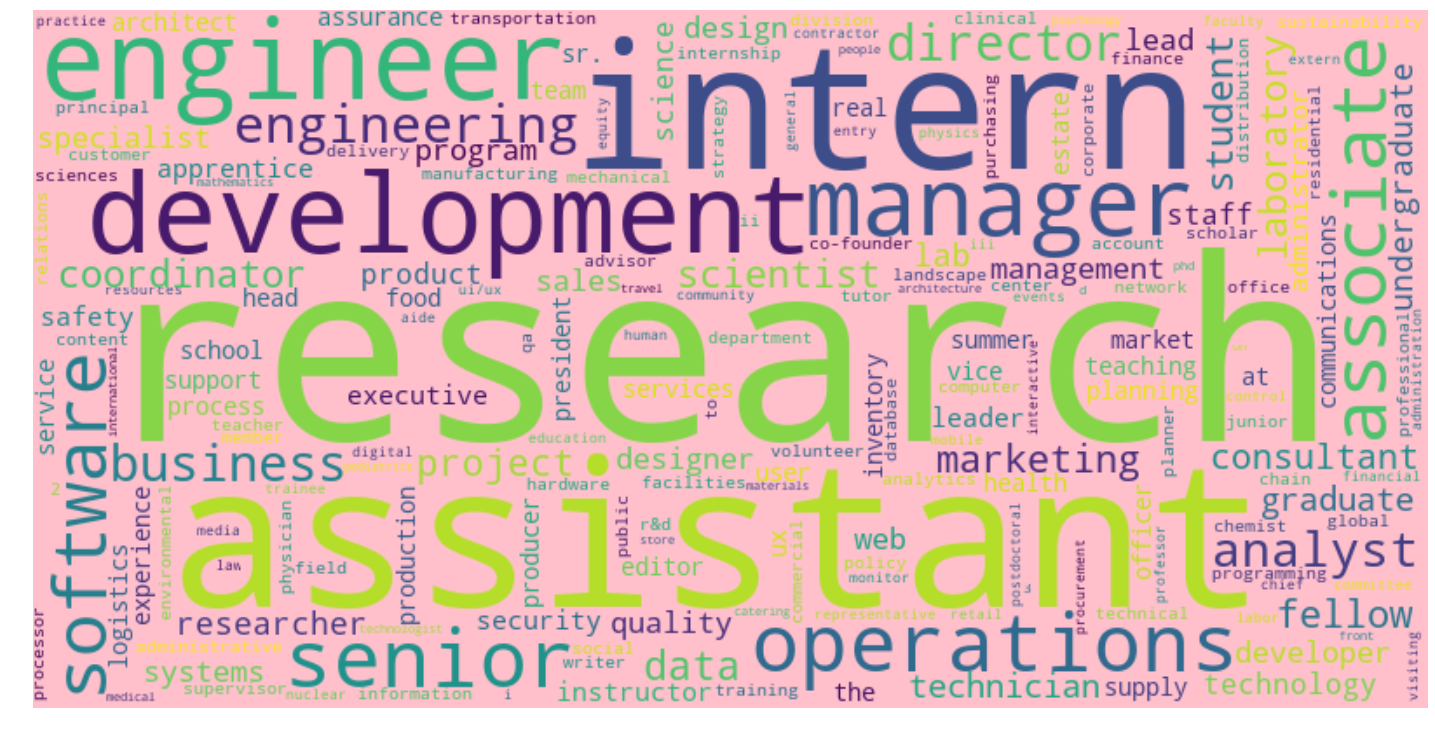

In [60]:
wordcloud = WordCloud(width = 800, height = 400,background_color = "pink")
wordcloud.generate_from_frequencies(frequencies=freq_b_f)
plt.figure(figsize = (25,35))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud for Berkeley-grad males Tech<a id='bm'></a> 

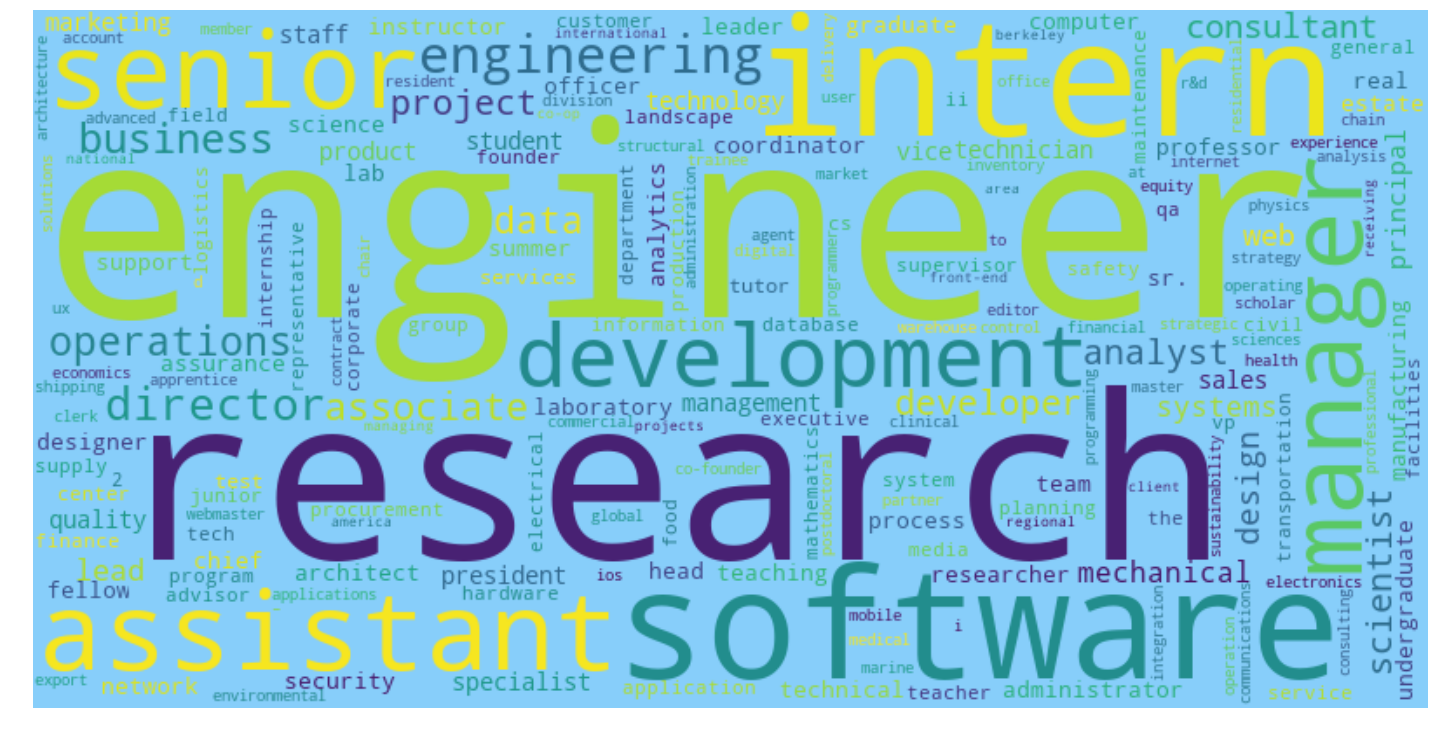

In [61]:
wordcloud = WordCloud(width = 800, height = 400,background_color = "lightskyblue")
wordcloud.generate_from_frequencies(frequencies=freq_b_m)
plt.figure(figsize = (25,35))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud for Non-Berkeley-grad females in Tech<a id='nf'></a> 

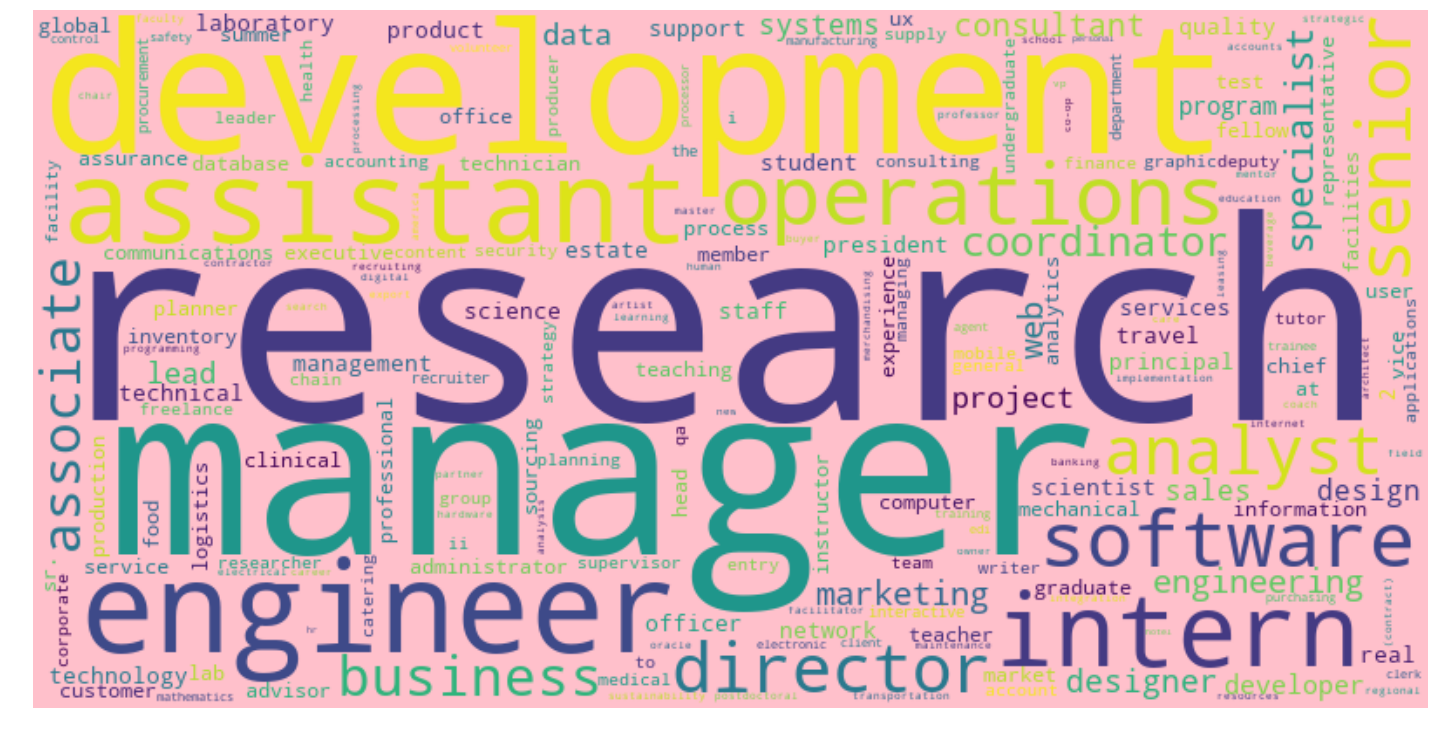

In [62]:
wordcloud = WordCloud(width = 800, height = 400,background_color = "pink")
wordcloud.generate_from_frequencies(frequencies=freq_nb_f)
plt.figure(figsize = (25,35))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud for Non-Berkeley-grad males in Tech<a id='nm'></a> 

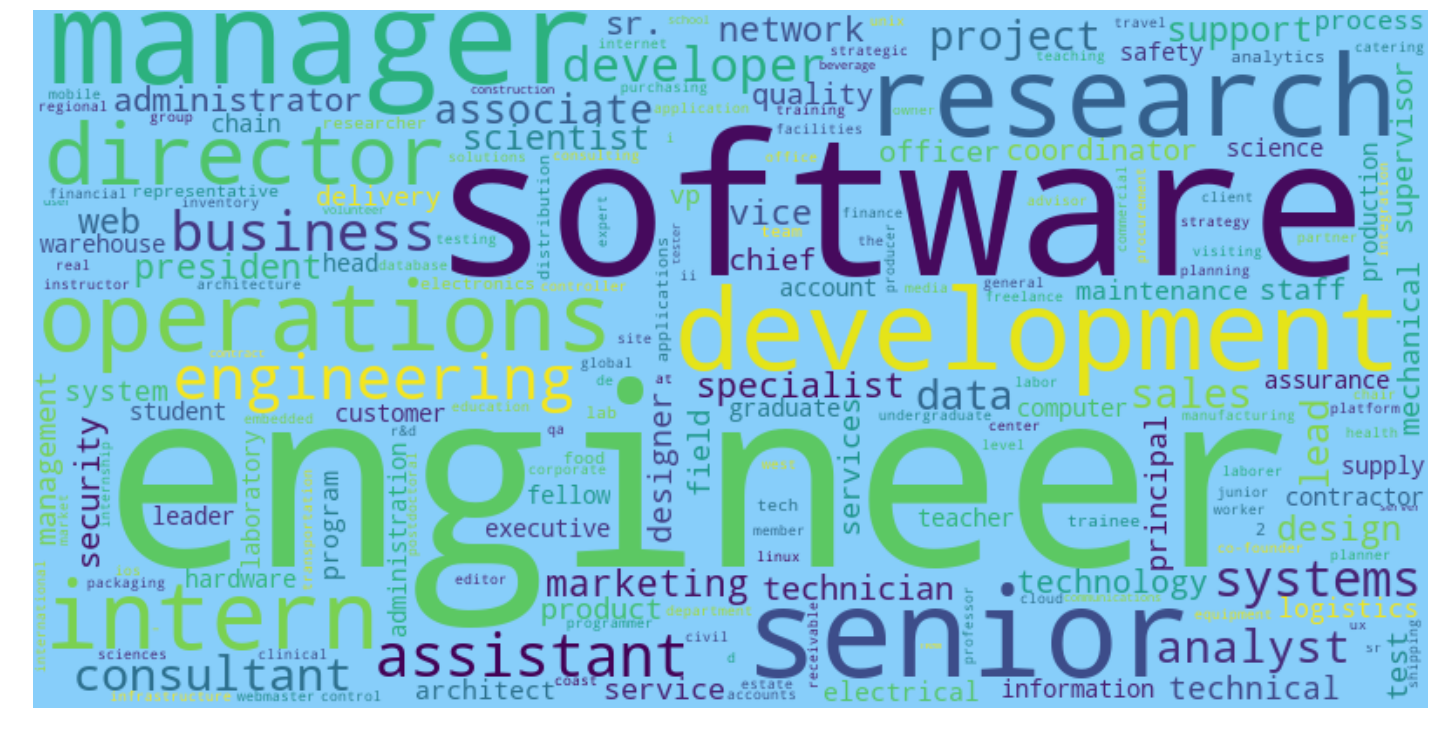

In [63]:
wordcloud = WordCloud(width = 800, height = 400,background_color = "lightskyblue")
wordcloud.generate_from_frequencies(frequencies=freq_nb_m)
plt.figure(figsize = (25,35))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Female vs Male
- Males have a more emphasis in software.
- Females have a more emphasis in  assistant titles.


Berkeley vs Non-Berkeley
- Research stands out more in Berkeley across females and males.
- Berkeley students have more internship positions
- Non-Berkeley students tend to have jobs with managers in the title.
- Director and Data are split evenly across all.


C:\Users\talin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0, 'Accounting and Auditing'),
 Text(0, 0, 'Administration'),
 Text(0, 0, 'Banking and Finance'),
 Text(0, 0, 'Business Development'),
 Text(0, 0, 'CRM and Sales Management'),
 Text(0, 0, 'Construction Management'),
 Text(0, 0, 'Data Analysis'),
 Text(0, 0, 'Digital Marketing'),
 Text(0, 0, 'Education'),
 Text(0, 0, 'Electrical Engineering'),
 Text(0, 0, 'Energy, Oil, and Gas'),
 Text(0, 0, 'Graphic Design'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Hospitality'),
 Text(0, 0, 'Human Resources (Junior)'),
 Text(0, 0, 'Human Resources (Senior)'),
 Text(0, 0, 'IT Management and Support'),
 Text(0, 0, 'Industrial Management'),
 Text(0, 0, 'Insurance'),
 Text(0, 0, 'Legal'),
 Text(0, 0, 'Logistics'),
 Text(0, 0, 'Manufacturing and Process Management'),
 Text(0, 0, 'Middle Management'),
 Text(0, 0, 'Military'),
 Text(0, 0, 'Mobile Telecommunications'),
 Text(0, 0, 'Musical Production'),
 Text(0, 0, 'Non-Profit and Community'),
 Text(0, 0, 'Operations Management'),
 Text(0, 0, 'Person

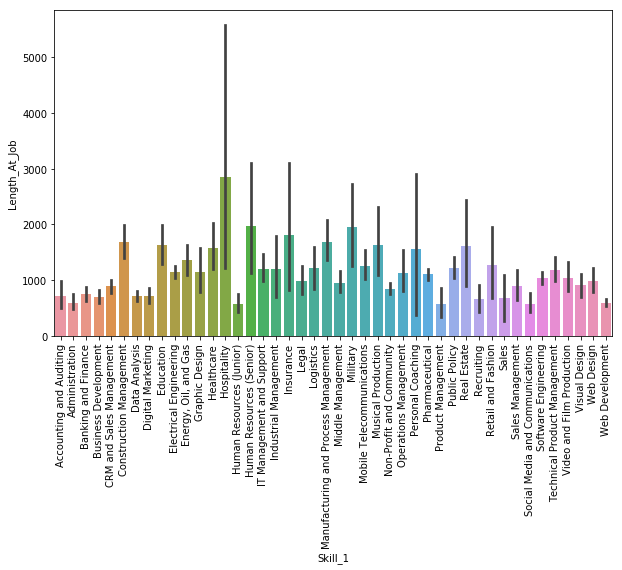

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
tech = tech_berk[tech_berk['Skill_1'] != '-1']
tech = tech.sort_values('Skill_1')
g = sns.barplot(x=tech['Skill_1'], y=tech['Length_At_Job'])
g.set_xticklabels(labels = tech['Skill_1'].unique(), rotation=90)

[Text(0, 0, 'Accounting and Auditing'),
 Text(0, 0, 'Administration'),
 Text(0, 0, 'Banking and Finance'),
 Text(0, 0, 'Business Development'),
 Text(0, 0, 'CRM and Sales Management'),
 Text(0, 0, 'Construction Management'),
 Text(0, 0, 'Data Analysis'),
 Text(0, 0, 'Digital Marketing'),
 Text(0, 0, 'Education'),
 Text(0, 0, 'Electrical Engineering'),
 Text(0, 0, 'Energy, Oil, and Gas'),
 Text(0, 0, 'Graphic Design'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Hospitality'),
 Text(0, 0, 'Human Resources (Junior)'),
 Text(0, 0, 'Human Resources (Senior)'),
 Text(0, 0, 'IT Management and Support'),
 Text(0, 0, 'Industrial Management'),
 Text(0, 0, 'Insurance'),
 Text(0, 0, 'Legal'),
 Text(0, 0, 'Logistics'),
 Text(0, 0, 'Manufacturing and Process Management'),
 Text(0, 0, 'Middle Management'),
 Text(0, 0, 'Military'),
 Text(0, 0, 'Mobile Telecommunications'),
 Text(0, 0, 'Musical Production'),
 Text(0, 0, 'Non-Profit and Community'),
 Text(0, 0, 'Operations Management'),
 Text(0, 0, 'Person

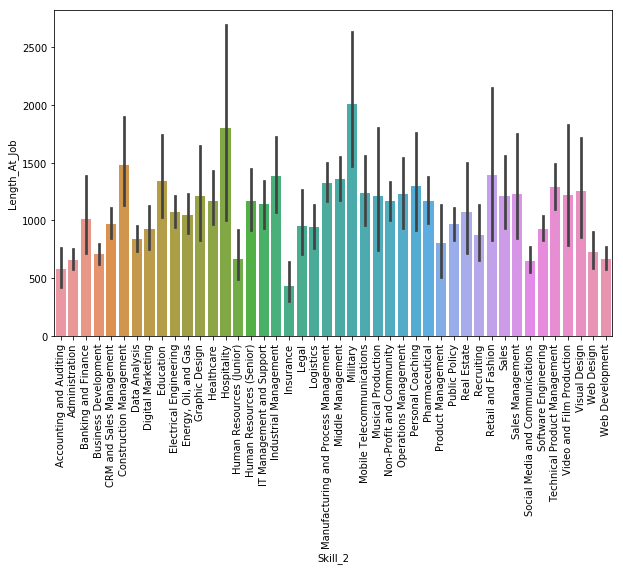

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
tech = tech_berk[tech_berk['Skill_2'] != '-1']
tech = tech.sort_values('Skill_2')
g = sns.barplot(x=tech['Skill_2'], y=tech['Length_At_Job'])
g.set_xticklabels(labels = tech['Skill_2'].unique(), rotation=90)

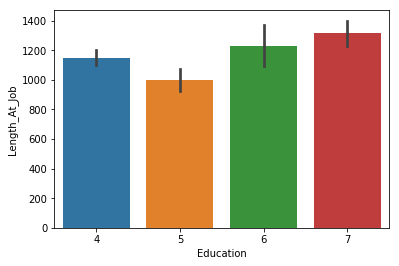

In [66]:
sns.barplot(x = tech_berk.groupby('ID').first().reset_index()['Education'], 
            y=tech_berk.groupby('ID').first().reset_index()['Length_At_Job'])

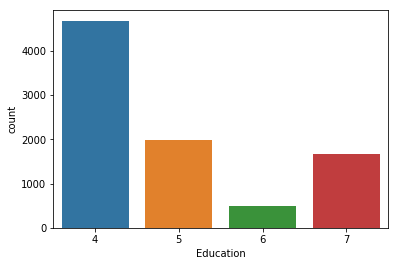

In [67]:
sns.countplot(x = tech_berk.groupby('ID').first().reset_index()['Education'])

### Removing data values with Birth Year 2001 because they were the default values and we are analyzing Birth_Years

In [68]:
tech_berk_age = tech_berk[tech_berk['Birth_Year'] != 2001]
tech_non_berk_age = tech_non_berk[tech_non_berk['Birth_Year'] != 2001]

In [69]:
tech_berk_age.reset_index(drop = True, inplace = True)

In [70]:
tech_berk.to_csv('Tech_Berk.csv')

### Retrieving actual ages from the given birth years

In [71]:
ages_berk = pd.Series([2019 - int(i) if i != 'None' else 0 for i in tech_berk_age['Birth_Year']])
ages_non_berk = ages_berk = pd.Series([2019 - int(i) if i != 'None' else 0 for i in tech_non_berk_age['Birth_Year']])

In [72]:
tech_berk_age['Age'] = ages_berk
tech_non_berk_age['Age'] = ages_non_berk

C:\Users\talin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
tech_berk_age_fem = tech_berk_age[tech_berk_age["Gender"] == 2]
tech_berk_age_m = tech_berk_age[tech_berk_age["Gender"] == 1]
tech_non_berk_age_fem = tech_non_berk_age[tech_non_berk_age["Gender"] == 2]
tech_non_berk_age_m = tech_non_berk_age[tech_non_berk_age["Gender"] == 1]

C:\Users\talin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\talin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

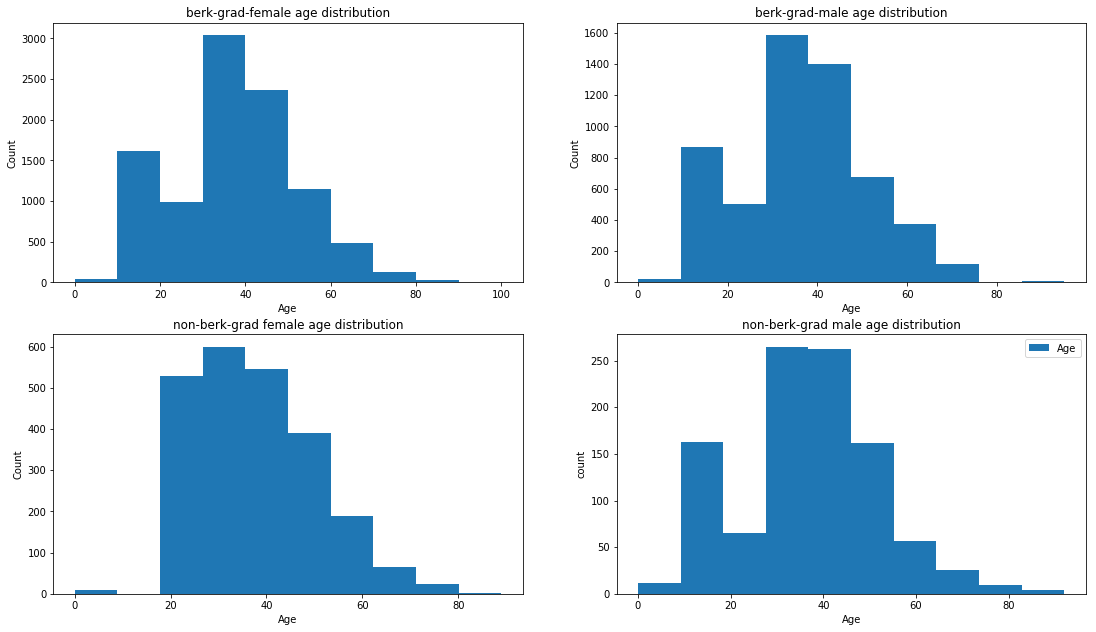

In [74]:
fig = plt.gcf()
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].hist(tech_berk_age_fem["Age"], bins = 10)
ax[0,0].set_title("berk-grad-female age distribution")
ax[0,0].set_xlabel("Age")
ax[0,0].set_ylabel("Count")


ax[0,1].hist(tech_berk_age_m["Age"], bins = 10)
ax[0,1].set_title("berk-grad-male age distribution")
ax[0,1].set_xlabel("Age")
ax[0,1].set_ylabel("Count")

ax[1,0].hist(tech_non_berk_age_fem["Age"], bins = 10)
ax[1,0].set_title("non-berk-grad female age distribution")
ax[1,0].set_xlabel("Age")
ax[1,0].set_ylabel("Count")

ax[1,1].hist(tech_non_berk_age_m["Age"], bins = 10)
ax[1,1].set_title("non-berk-grad male age distribution")
ax[1,1].set_xlabel("Age")
ax[1,1].set_ylabel("Count")

fig.set_size_inches(18.5, 10.5, forward=True)
plt.xlabel('Age')
plt.ylabel("count")
plt.legend()


# Implementation for Duration<a id='implementation'></a> 

In [80]:
def all_in_one(edu, job):
    # returns a table with the last education, the first tech job 
    #post the last education date, the duration between these two dates, 
    #along with the attributes of each unique candidate.
    def last_education(edu):
        if len(edu) > 0:
            return max(list(edu['End_Date']))
        return 'None'

    def first_tech_job(last_edu, job):
        #returns indexes of the education table that was passed in
        # and their corresponding First Job Start_Date after their
        #latest Educations 
        first_job = 'None'
        if len(job) > 0:
            job_dates = sorted(job['Start_Date'])
            for i in job_dates:
                if i >= last_edu:
                    return i
        return first_job
    
    def days_between(d1, d2):
    # returns the amounts of days between to string datetime objects
        d1 = datetime.strptime(d1, "%Y-%m-%d")
        d2 = datetime.strptime(d2, "%Y-%m-%d")
        return abs((d2 - d1).days)

    edu_id = edu['ID'].unique()
    job = job[job['ID'].isin(edu_id)]
    f = FloatProgress(min=0, max=len(edu_id))
    display(f)
    result = pd.DataFrame(columns=['ID', 'Last_Edu', 'First_Job', 'Duration'])
    for unique_id in edu_id:
        edu_subtable = edu[edu['ID'] == unique_id]
        job_subtable = job[job['ID'] == unique_id]
        last_edu_date = last_education(edu_subtable)
        if last_edu_date != 'None':
            first_job = first_tech_job(last_edu_date, job_subtable)
            if first_job != 'None':
                duration = days_between(last_edu_date, first_job)
                result = result.append({'ID': unique_id, 
                                        'Last_Edu': last_edu_date, 
                                        'First_Job': first_job,
                                       'Duration' : duration}, 
                                       ignore_index = True)
        f.value += 1
    edu_filter = edu[edu["ID"].isin(result['ID'].unique())]
    final = result.merge(edu_filter, on = 'ID').groupby('ID').first().reset_index(drop = False)
    return final


In [81]:
final_df_berk = all_in_one(berk_edu, tech_berk)

FloatProgress(value=0.0, max=16590.0)

In [82]:
final_df_berk.to_csv('final_df_berkeley.csv')

In [83]:
final_df_berk

,ID,Last_Edu,First_Job,Duration,Birth_Year,Gender,Skill_1,Skill_1_Weight,Skill_2,Skill_2_Weight,...,End_Date,Valid_End_Date,Current_Employer_Flag,Length_At_Job,Role,Department,Company,Industry,Education_Flag,Degree_Type
0,00215b9f-1d2e-31f8-8488-1df56555eb06,2009-01-01,2014-01-01,1826,1978,0,CRM and Sales Management,0.554744,Business Development,0.311882,...,1996-01-01,False,False,1461.0,"""b.eee, electrical & electronics engineering"",...",NaN,?,NaN,True,4.0
1,003dd6be-0e95-3c52-9aa5-95cd4363a213,1981-01-01,1989-11-01,3226,1955,2,-1,0.000000,-1,0.000000,...,1977-01-01,False,False,1461.0,"""bs, civil engineering"",civil engineering",NaN,"California State University, Fresno",NaN,True,4.0
2,003e5096-9bee-30e1-9919-12e915e17d73,2014-01-01,2015-08-01,577,1991,0,Data Analysis,0.231798,Administration,0.220937,...,2014-01-01,False,False,1826.0,"""b.a., applied mathematics"",b.a.,applied mathe...",NaN,"University of California, Berkeley",NaN,True,4.0
3,004c3b88-6abe-3e5c-b7bf-f50181a86233,1998-01-01,1998-08-01,212,1958,2,Electrical Engineering,0.543340,"Energy, Oil, and Gas",0.301323,...,1988-01-01,False,False,1826.0,"""b.s. (high honors), materials science & engin...",NaN,University of Florida,NaN,True,4.0
4,00548460-abc3-3f5f-b87f-e6c7a473c9e6,2011-01-01,2011-07-01,181,1989,2,-1,0.000000,-1,0.000000,...,2011-01-01,False,False,1461.0,"""b.s., electrical engineering and computer sci...",NaN,"University of California, Berkeley",NaN,True,4.0
5,005d04f5-a202-355c-a840-84085d8a76c0,2003-01-01,2006-01-01,1096,1971,0,-1,0.000000,-1,0.000000,...,1995-01-01,False,False,1461.0,"""b.a., applied mathematics & economics"",b.a.,a...",NaN,Pinole Valley High School,NaN,True,4.0
6,0068fdf0-26ac-3c68-ac0b-f3e388efa320,2013-01-01,2014-02-01,396,1982,2,-1,0.000000,-1,0.000000,...,2011-01-01,False,False,1461.0,"""bachelor of science (b.s.), aerospace, aerona...",NaN,Purdue University,NaN,True,4.0
7,006b8122-2683-3fff-9a39-7ab4bf67deba,2001-01-01,2003-10-01,1003,1963,2,-1,0.000000,-1,0.000000,...,1986-01-01,False,False,1826.0,"""ba - management of nonprofit organization, no...",NaN,World College West,NaN,True,4.0
8,007bd11c-783d-3020-89ed-09816f43175c,2012-01-01,2013-01-01,366,1989,2,-1,0.000000,-1,0.000000,...,2009-01-01,False,False,1461.0,"""bachelor of science (b.s.), chemical engineer...",NaN,Troy High School,NaN,True,4.0
9,0099004a-2a2d-3cef-8205-09f43d8fb68b,1985-01-01,1985-11-01,304,1953,2,-1,0.000000,-1,0.000000,...,1975-01-01,False,False,1461.0,"""ba, molecular biology"",molecular biology",NaN,Colgate University,NaN,True,4.0


In [84]:
final_df_non_berk = all_in_one(non_berk_edu, tech_non_berk)

FloatProgress(value=0.0, max=162587.0)

In [85]:
final_df_non_berk.to_csv('final_df_non_berkeley.csv')

In [86]:
final_df_non_berk

,ID,Last_Edu,First_Job,Duration,Birth_Year,Gender,Skill_1,Skill_1_Weight,Skill_2,Skill_2_Weight,...,End_Date,Valid_End_Date,Current_Employer_Flag,Length_At_Job,Role,Department,Company,Industry,Education_Flag,Degree_Type
0,0012fb14-7ee2-3fb6-b90c-c067458c2751,2012-01-01,2014-03-01,790,1984,1,-1,0.000000,-1,0.000000,...,2010-01-01,False,False,1461.0,"""bachelor's degree, industrial engineering"",ba...",NaN,Shanghai Jiao Tong University,NaN,True,4.0
1,0022150c-6d8a-3985-b037-5385f5ea6bcd,1983-01-01,2013-01-01,10958,1958,2,Non-Profit and Community,0.530755,Public Policy,0.373232,...,1980-01-01,False,False,1461.0,"""bachelor's degree, political science and musi...",NaN,Columbia College (NY),NaN,True,4.0
2,00344289-76a1-385b-a98f-e692bd1167d7,2010-01-01,2013-04-01,1186,1985,0,Business Development,0.592793,Sales,0.149266,...,2010-01-01,False,False,365.0,"""graduate diploma, international business"",gra...",NaN,The Northern Consortium of the United Kingdom,NaN,True,5.0
3,003d5c58-5843-34eb-8d39-a926cb386b75,2009-01-01,2010-06-01,516,1986,1,-1,0.000000,-1,0.000000,...,2009-01-01,False,False,1827.0,"""b.s. recreation administration, event plannin...",NaN,California State University-Chico,NaN,True,4.0
4,00426f85-175c-3aab-bc9d-7663bb7943bb,2010-01-01,2015-03-01,1885,1987,2,-1,0.000000,-1,0.000000,...,2010-01-01,False,False,1096.0,"""bachelor of applied science (b.a.sc.), sound ...",NaN,ECDA,NaN,True,4.0
5,004c7382-c608-3e9c-a263-58c09f1e75e9,1993-01-01,2011-03-01,6633,1972,0,Business Development,0.360820,Social Media and Communications,0.312543,...,1993-01-01,False,False,1096.0,"""bs, business administration and management, g...",NaN,California State University-Sacramento,NaN,True,4.0
6,00616d39-d62e-370a-bda6-596b373deb5c,2005-01-01,2005-12-01,334,1983,0,-1,0.000000,-1,0.000000,...,2005-01-01,False,False,1461.0,"bachelor,bachelor",NaN,-,NaN,True,4.0
7,00869266-df55-3987-a1b3-e9486e1a9b34,2013-01-01,2013-01-01,0,1981,2,Graphic Design,0.492450,Web Design,0.238737,...,2004-01-01,False,False,1095.0,"""bachelor of arts (ba), fine/studio arts, pain...",NaN,San Jose State University,NaN,True,4.0
8,00905ffc-dbab-3a56-95e7-604238dd49b0,2000-01-01,2000-05-01,121,1976,1,-1,0.000000,-1,0.000000,...,2000-01-01,False,False,730.0,"""master’s degree, information technology, 3.96...",NaN,Rochester Institute of Technology,NaN,True,5.0
9,0091ada1-60d9-3ba3-99e5-82e3e1406bcb,2011-01-01,2013-09-01,974,1986,2,-1,0.000000,-1,0.000000,...,2007-01-01,False,False,1096.0,"""be, mechanical engineering"",mechanical engine...",NaN,NED University of Engineering and Technology,NaN,True,4.0


# Duration between Last Education and First Tech Job<a id='duration'></a> 

In [87]:
final_df_berk.head()

,ID,Last_Edu,First_Job,Duration,Birth_Year,Gender,Skill_1,Skill_1_Weight,Skill_2,Skill_2_Weight,...,End_Date,Valid_End_Date,Current_Employer_Flag,Length_At_Job,Role,Department,Company,Industry,Education_Flag,Degree_Type
0,00215b9f-1d2e-31f8-8488-1df56555eb06,2009-01-01,2014-01-01,1826,1978,0,CRM and Sales Management,0.554744,Business Development,0.311882,...,1996-01-01,False,False,1461.0,"""b.eee, electrical & electronics engineering"",...",NaN,?,NaN,True,4.0
1,003dd6be-0e95-3c52-9aa5-95cd4363a213,1981-01-01,1989-11-01,3226,1955,2,-1,0.000000,-1,0.000000,...,1977-01-01,False,False,1461.0,"""bs, civil engineering"",civil engineering",NaN,"California State University, Fresno",NaN,True,4.0
2,003e5096-9bee-30e1-9919-12e915e17d73,2014-01-01,2015-08-01,577,1991,0,Data Analysis,0.231798,Administration,0.220937,...,2014-01-01,False,False,1826.0,"""b.a., applied mathematics"",b.a.,applied mathe...",NaN,"University of California, Berkeley",NaN,True,4.0
3,004c3b88-6abe-3e5c-b7bf-f50181a86233,1998-01-01,1998-08-01,212,1958,2,Electrical Engineering,0.543340,"Energy, Oil, and Gas",0.301323,...,1988-01-01,False,False,1826.0,"""b.s. (high honors), materials science & engin...",NaN,University of Florida,NaN,True,4.0
4,00548460-abc3-3f5f-b87f-e6c7a473c9e6,2011-01-01,2011-07-01,181,1989,2,-1,0.000000,-1,0.000000,...,2011-01-01,False,False,1461.0,"""b.s., electrical engineering and computer sci...",NaN,"University of California, Berkeley",NaN,True,4.0


In [88]:
berkeley_unique = final_df_berk.groupby('ID').first()

Text(0.5, 1.0, 'Days between Last Education and First Job vs Count')

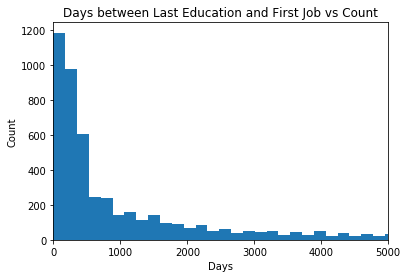

In [89]:
plt.hist(berkeley_unique['Duration'], bins = 100)
plt.xlim((0,5000))
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Days between Last Education and First Job vs Count')

In [90]:
# id_code = '9f930a31-d53e-3a2e-80cf-8210f0b45d47'
# ex_edu = valid_berkeley_sample[valid_berkeley_sample['ID'] == id_code]
# ex_job = tech_berk[tech_berk['ID'] == id_code]

In [91]:
# ex_edu['End_Date']

In [92]:
# ex_job['Start_Date']

# Linear Regression for Berkeley Alumni<a id='lrb'></a> 

In [172]:
def process_data(data, test = False):
    X = data.pipe(select_columns, 'skill1xweight', 'skill2xweight', 'Education')
    #X, y = X, data['Duration']
    if test:
        y = [1] *len(data)
    else:
        y = data['Duration']
        
    return X, y
def select_columns(data, *columns):
    return data.loc[:, columns]

# Loss Function<a id='lf'></a> 

In [173]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

# Berkeley Alumni Linear Regression Model for Duration<a id='bm'></a> 

In [174]:
berkeley_unique['ID'] = berkeley_unique.index

In [219]:
skill_level = ['CRM and Sales Management', 'Hospitality',
       'Non-Profit and Community',
       'Middle Management', 'Public Policy', 'Military',
        'Pharmaceutical',
       'Administration', 'Personal Coaching',
       'Sales Management', 'Musical Production', 
       'Video and Film Production', 'Healthcare',
       'Retail and Fashion','Human Resources (Junior)', 'Insurance', 'Real Estate',
       'Construction Management', '-1', 'Accounting and Auditing', 'Sales',
       'Energy, Oil, and Gas', 'Mobile Telecommunications', 'Legal', 'Banking and Finance', 'Business Development',
       'Social Media and Communications',
       'Education', 'Digital Marketing', 'Recruiting','Manufacturing and Process Management',  'Logistics', 'Visual Design', 'Graphic Design', 'Web Design',
       'Human Resources (Senior)', 'Operations Management', 'Product Management', 'Technical Product Management', 'IT Management and Support',
       'Industrial Management','Web Development','Electrical Engineering', 'Software Engineering', 'Data Analysis']


# {'Software Engineering': 45, 'Data Analysis': 44, 'Web Design': 43, 'Technical Product Management': 42, 'Product Management': 41
#  'Visual Design': 39, 'IT Management and Support': 40, 'Digital Marketing': 38, 'Graphic Design': 39, 'Electrical Engineering': 45, 
#  'Manufacturing and Process Management': 38, 'Accounting and Auditing': 37}
skills = {}
weight = 0
for skill in skill_level:
    skills[skill] = weight
    weight += 1
    

In [221]:
berkeley_unique['skill1xweight'] = [skills[berkeley_unique.iloc[i]['Skill_1']] * 
                                    berkeley_unique.iloc[i]['Skill_1_Weight']  for i in range(len(berkeley_unique))]

In [222]:
berkeley_unique['skill2xweight'] = [skills[berkeley_unique.iloc[i]['Skill_2']] * 
                                    berkeley_unique.iloc[i]['Skill_2_Weight']  for i in range(len(berkeley_unique))]

In [253]:
test_df = test_df.groupby('ID').first().reset_index(drop = False)

In [254]:
test_df['skill1xweight'] = [skills[test_df.iloc[i]['Skill_1']] * 
                            test_df.iloc[i]['Skill_1_Weight']  for i in range(len(test_df))]

In [255]:
test_df['skill2xweight'] = [skills[test_df.iloc[i]['Skill_2']] * 
                            test_df.iloc[i]['Skill_2_Weight']  for i in range(len(test_df))]

In [256]:
train_df_lr = berkeley_unique[berkeley_unique['ID'].isin(train_df_id)]
val_df_lr = berkeley_unique[berkeley_unique['ID'].isin(val_df_id)]

In [257]:
X_train, y_train = process_data(train_df_lr)
X_val, y_val = process_data(val_df_lr)
guided_model = linear_model.LinearRegression(fit_intercept=True)
guided_model.fit(X_train, y_train)
#predictions
y_train_pred = guided_model.predict(X_train)
y_val_pred = guided_model.predict(X_val)

In [258]:
guided_model.score(X_train, y_train)

0.007521238514653139

In [259]:
X_test, y_test = process_data(test_df, True)

In [260]:
np.mean(train_df_lr['Duration'])

1547.4621050130672

In [261]:
mae((train_df_lr['Duration']), y_train_pred)

1653.393239497555

In [262]:
mae((val_df_lr['Duration']), y_val_pred)

1612.6116406897802

C:\Users\talin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


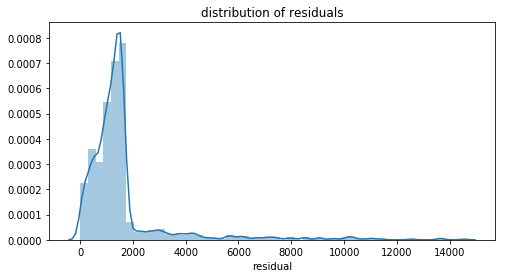

In [263]:
plt.figure(figsize=(8,4))
sns.distplot(np.abs(y_val - y_val_pred))
plt.xlabel('residual')
plt.title('distribution of residuals');

In [264]:
y_pred = guided_model.predict(X_test)

In [265]:
len(X_test)== len(y_pred)==len(y_test)

True

In [266]:
final_model = linear_model.Lasso(alpha= .1)
final_model.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [267]:
X_test, _ = process_data(test_df, True)
final_predictions = final_model.predict(X_test)
# final_predictions = final_predictions.astype(int)

In [268]:
final_predictions

array([1601.78796631, 1364.60493457, 1288.61338145, ..., 1480.96269658,
       1754.09029283, 1637.03560872])

In [269]:
df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})

In [270]:
df1 = df.sample(30)

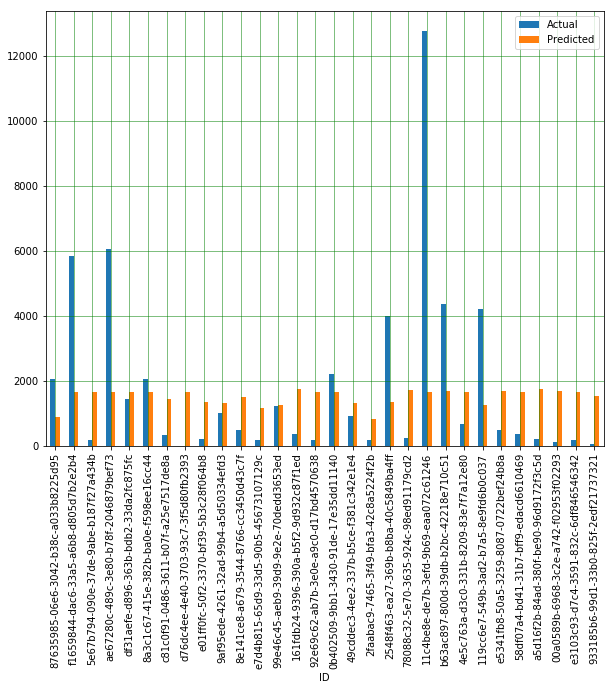

In [271]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Non-Berkeley Alumni Linear Regression Model for Duration<a id='bm'></a> 
______________________

In [ ]:
#### 

In [ ]:
plt.hist(table_berk['Duration'], bins = 100)
plt.xlim((0,5000))
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Days between Last Education and First Job vs Count')

# Explanation 

In [ ]:
plt.hist(table_non_berk['Duration'], bins = 100)
plt.xlim((0,5000))
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Days between Last Education and First Job vs Count')

# Explanation 

In [ ]:
table_berk_filtered = table_berk[table_berk['Duration'] <= 1500]
table_berk_filtered.to_csv('Table_Berk_Filtered.csv')

In [ ]:
table_non_berk_filtered = table_non_berk[table_non_berk['Duration'] <= 1500]
table_non_berk_filtered.to_csv('Table_Non_Berk_Filtered.csv')

_____________________________

# Data Schema<a id='ds'></a> 

[Column 0] ID

[Column 1] Birth year: where available

[Column 2] Gender flag: 1=female, 2=male, 0=unknown

[Column 3] Skillset1: primary skillset deduced from self-reported skills

[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall
self-reported skills

[Column 5] Skillset2: secondary skillset deduced from self-reported skills

[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of
overall self-reported skills

[Column 7] City of profile (does not change): where unavailable, the field is left blank

[Column 8] Country of Profile (does not change)

[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school;
2=vocational degree; 3=associate's; 4=bachelor's; 5=master's other than MBA; 6=MBA;
7=doctorate (PhD/JD/MD)

[Column 10] Elite institution: a flag indicating whether any of the person's main degrees
came from an elite (top 100) institution [NB: Romanian names not covered]

[Column 11] Start date

[Column 12] Flag: Is the start month valid?

[Column 13] End date

[Column 14] Flag: Is the end month valid?

[Column 15] Flag: Is this their current employment?

[Column 16] Length: length of time spent at the given job (days)

[Column 17] Role: the self-reported job role, followed by the normalized job title (the two
are separated by a comma)

[Column 18] Department: the self-reported job role, followed by the associated
department, if it's possible to tell (the two are separated by a comma)

[Column 19] Company name

[Column 20] Normalized company name: accounts for things like subsidiaries, etc.

[Column 21] Ticker: also included are tickers for private company, where available from
sources like Bloomberg (not that good; but the public company ones, coming from
exchanges, are pretty comprehensive); for things like universities, government jobs, etc.
these are demarcated accordingly (e.g., FREELANCE is the ticker for self-employed)

[Column 22] Exchange: for disambiguated private companies or hard-coded roles it's just
the country location

[Column 23] Flag for whether the firm is publicly traded

[Column 24] Location of Employment

[Column 25] Industry (NAICS)

[Column 26] Education flag: True=this entry reflects an education record;
False=employment record

[Column 27] Degree type: 0=none/unknown; 1=high school; 2=vocational degree;
3=associate's; 4=bachelor's; 5=master's other than MBA; 6=MBA; 7=doctorate
(PhD/JD/MD); empty if it's not an education record

[Column 28] Elite flag: True=education record from an elite (top 100) institution; False=not
an education record, or education record from a non-elite institution

[Column 29] Majors

[Column 30] Major Categories

[Column 31] Industry (NAICS)

[Column 32] Education flag: True=this entry reflects an education record;
False=employment record